In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [4]:
blocks = gpd.read_file("../data/blocks/tl_2020_23_tabblock20_with_nodes.shp.zip")

In [5]:
conserved_lands = gpd.read_file("../data/conserved_lands/Maine_Conserved_Lands_with_nodes.shp.zip")

In [6]:
df = pd.read_csv("../data/walk_times/walk_times_block_df.csv", index_col=0)
df.columns

Index(['tract_osmid', 'land_osmid', 'trip_time'], dtype='object')

In [7]:
df_with_lands = df.merge(conserved_lands.drop(columns='geometry'), how="left", left_on="land_osmid", right_on="osmid")
df_with_lands.head(1)

,tract_osmid,land_osmid,trip_time,created_us,created_da,last_edite,last_edi_1,PROJECT,PARCEL_NAM,DESIGNATIO,...,GAP_STATUS,IUCN_STATU,CL_UNIQUEI,GlobalID,TAX_MAP_TO,TAX_MAP_BO,OBJECTID,ShapeSTAre,ShapeSTLen,osmid
0,9124869045,9124869022,45,MECONSLANDS,2023-03-18,MECONSLANDS,2023-03-18,Hebert Farm,NaN,NaN,...,39-Permanently Secured and in agriculture or m...,NaN,27062,{D52D3FC6-FF1C-4BCA-9D00-053D63CA2DFA},NaN,NaN,22726,643531.690857,3913.651662,9124869022


In [8]:
merge = gpd.GeoDataFrame(blocks.merge(df_with_lands, how="outer", left_on="osmid", right_on="tract_osmid"))
merge.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'osmid_x', 'geometry', 'tract_osmid', 'land_osmid', 'trip_time',
       'created_us', 'created_da', 'last_edite', 'last_edi_1', 'PROJECT',
       'PARCEL_NAM', 'DESIGNATIO', 'CONS1_TYPE', 'HOLD1_NAME', 'HOLD1_TYPE',
       'CONS2_TYPE', 'HOLD2_NAME', 'HOLD2_TYPE', 'ECO_RESERV', 'ACQ_YEAR',
       'ACQ_DATE', 'RPT_AC', 'PUB_ACCESS', 'PURPOSE1', 'PURPOSE2', 'EDITOR',
       'BPL_ID', 'IFW_ID', 'LMF_ID', 'DEPT_ID', 'FMPROCSS', 'FMUPDDAT',
       'NOTE_', 'CALC_AC', 'REVIEW', 'GAP_STATUS', 'IUCN_STATU', 'CL_UNIQUEI',
       'GlobalID', 'TAX_MAP_TO', 'TAX_MAP_BO', 'OBJECTID', 'ShapeSTAre',
       'ShapeSTLen', 'osmid_y'],
      dtype='object')

In [9]:
trip_times = merge["trip_time"].dropna().unique().astype(int)
trip_times.sort()

In [10]:
for time in trip_times:
    # copy acres column
    merge["AC_"+str(time)] = merge["CALC_AC"]
    # delete values for non-matching times
    merge["AC_"+str(time)][np.logical_not(merge["trip_time"] == time)] = pd.NA

/tmp/ipykernel_2588/1919367070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge["AC_"+str(time)][np.logical_not(merge["trip_time"] == time)] = pd.NA
/tmp/ipykernel_2588/1919367070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge["AC_"+str(time)][np.logical_not(merge["trip_time"] == time)] = pd.NA
/tmp/ipykernel_2588/1919367070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge["AC_"+str(time)][np.logical_not(me

In [11]:
trip_cols = ["AC_"+str(time) for time in trip_times]

In [12]:
ac_sums = pd.concat([merge.dropna(subset=col).groupby("BLOCKCE20")[col].sum() for col in trip_cols], axis=1)

<AxesSubplot: xlabel='value', ylabel='Count'>

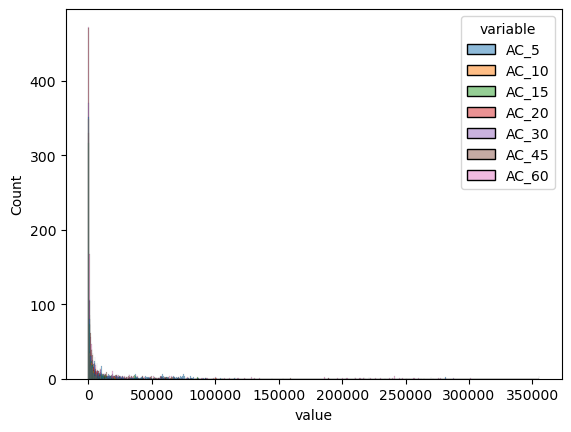

In [13]:
sns.histplot(ac_sums.melt(), x="value", hue="variable")

In [14]:
dissolve = merge.dissolve("GEOID20", "sum")

/home/philip/miniconda3/envs/ox/lib/python3.11/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [15]:
dissolve.to_file("../data/joins/block_dissolve.shp.zip")

/tmp/ipykernel_2588/1154593663.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dissolve.to_file("../data/joins/block_dissolve.shp.zip")


In [16]:
desc = dissolve[dissolve["AC_10"] > 0]["AC_10"].describe()
desc

count      6958.000000
mean        136.260062
std        1870.668954
min           0.004726
25%           3.631041
50%          12.395381
75%          39.522687
max      100409.906189
Name: AC_10, dtype: float64

Text(0.5, 1.0, 'Acres of Conserved Land within 60 Minute Walk of Block Center')

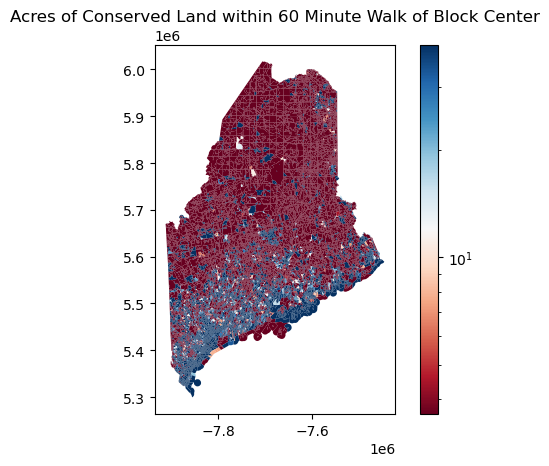

In [19]:
ax = dissolve.plot("AC_60", cmap="RdBu", legend=True, norm=LogNorm(desc["25%"], desc["75%"], clip=True))
ax.set_title("Acres of Conserved Land within 60 Minute Walk of Block Center")